In [ ]:
# DO NOT REMOVE

# Compute double truncated GR from seismicity

In [8]:
%matplotlib inline
import os
import re
import sys
import h5py
import numpy
try:
    import cPickle as pickle
except:
    import pickle

from collections import Counter
from prettytable import PrettyTable

from openquake.hmtk.seismicity.occurrence.weichert import Weichert
from openquake.hmtk.seismicity.occurrence.utils import get_completeness_counts
from openquake.hmtk.plotting.seismicity.occurrence.recurrence_plot import plot_trunc_gr_model

from oqmbt.oqt_project import OQtProject
from oqmbt.tools.area import create_catalogue

In [3]:
prj_path = "/Users/kjohnson/GEM/Regions/paisl18/project_6/paisl.oqmbtp"
os.environ["OQMBT_PROJECT"] = prj_path

In [4]:
project_pickle_filename = os.environ.get('OQMBT_PROJECT')
oqtkp = OQtProject.load_from_file(project_pickle_filename)
print ('Project filename:', project_pickle_filename)
model_id = oqtkp.active_model_id
model = oqtkp.models[model_id]
#
# hdf5 files
compl_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.compl_hdf5_filename)
eqk_rates_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.eqk_rates_hdf5_filename)
#
# set source ID
try:
    area_source_ids_list = getattr(oqtkp,'active_source_id')
except:
    print ('Active source ID not defined in the OQMBT project')
    area_source_ids_list = ['1']
#
# info 
print ('Processing model with ID:', model_id)
print ('Processing area source with ID:', area_source_ids_list)

Project filename: /Users/kjohnson/GEM/Regions/paisl18/project_6/paisl.oqmbtp
Active source ID not defined in the OQMBT project
Processing model with ID: model06
Processing area source with ID: ['1']


In [5]:
# Width of bins used to discretise the MFDs
binwidth = float(model.mfd_binwidth)

In [19]:
area_source_ids_list = ['7']

## Summary of GR parameters assigned to area sources

In [20]:
# Set table
p = PrettyTable(["ID","a_gr", "b_gr"])
p.align["Source ID"] = 'l'
p.align["a_gr"] = 'r'
p.align["b_gr"] = 'r'
#
for key in sorted(model.sources):
    src = model.sources[key]
    if src.source_type == 'AreaSource':
        alab = ''
        blab = ''
        if 'a_gr' in src.__dict__:
            alab = '%8.5f' % (src.a_gr)
        if 'b_gr' in src.__dict__:
            blab = '%6.3f' % (src.b_gr)    
        p.add_row([key, alab, blab])
print (p)

+----+----------+--------+
| ID |     a_gr |   b_gr |
+----+----------+--------+
| 1  |  3.18194 |  0.525 |
| 10 |          |        |
| 11 |          |        |
| 12 |          |        |
| 13 |          |        |
| 14 |          |        |
| 15 |          |        |
| 2  |          |        |
| 3  |          |        |
| 4  |          |        |
| 5  |          |        |
| 6  |          |        |
| 7  |          |        |
| 8  |          |        |
| 9  |          |        |
+----+----------+--------+


## Read catalogue

In [10]:
print (oqtkp.models[model_id].declustered_catalogue_pickle_filename)
pickle_filename = os.path.join(oqtkp.directory, oqtkp.models[model_id].declustered_catalogue_pickle_filename)
fin = open(pickle_filename, 'rb') 
catalogue = pickle.load(fin)
fin.close()
print ('The catalogue contains %d earthquakes' % (len(catalogue.data['magnitude'])))

model_6_-_new_classification,_new_area_sources_catalogue.pkl
The catalogue contains 5459 earthquakes


### Create catalogue for the selected areas

In [21]:
fcatal = create_catalogue(model, catalogue, area_source_ids_list)

163.6239 -10.538 0.0 -1529540.1140057002
165.1757 -10.2242 237923.96526600202 -1478825.3505753486
166.71 -10.43 474180.088481953 -1504707.720474877
165.789 -11.206 335586.882769769 -1629914.5921502477
165.17 -10.99 239077.97138391572 -1598018.5214150837
164.6 -10.94 150857.55659255123 -1591419.361501459
163.8876 -11.1473 40850.13659116273 -1624640.8488589271
163.6239 -10.538 0.0 -1529540.1140057002


In [22]:
mmin_model = float(model.catalogue_cutoff_magnitude)
print ('Minimum magnitude considered for the model is: ', mmin_model)
mmax_obs = float(max(fcatal.data['magnitude']))
print ('Maximum observed magnitude is: ', mmax_obs)

Minimum magnitude considered for the model is:  5.0
Maximum observed magnitude is:  7.08


### Load the completeness table

In [23]:
compl_hdf5_filename = os.path.join(oqtkp.directory, oqtkp.compl_hdf5_filename)
print ('Reading {:s}\n'.format(compl_hdf5_filename))
fhdf5 = h5py.File(compl_hdf5_filename,'r')

grp = fhdf5[model_id]
src_id = area_source_ids_list[0]
if src_id in grp.keys():
    compl_table = grp[src_id][()]
    print ('Found completeness table for: <%s>' % (src_id))
else:
    print ('The .hdf5 file does not contain completeness table for source {:s}'.format(src_id))
    if 'whole_catalogue' in grp.keys():
        compl_table = grp['whole_catalogue'][()]
        print ('Using the default completeness table set for the whole catalogue')
    else:
        print ('Default completeness table (whole catalogue) not defined')
        raise ValueError()
        compl_table = None
print ('\nCompleteness table:')
print (compl_table)
fhdf5.close()

Reading /Users/kjohnson/GEM/Regions/paisl18/project_6/completeness.hdf5

The .hdf5 file does not contain completeness table for source 7
Using the default completeness table set for the whole catalogue

Completeness table:
[[ 1990.      4. ]
 [ 1989.      4.5]
 [ 1969.      5. ]
 [ 1963.      5.5]
 [ 1930.      6. ]
 [ 1930.      6.5]
 [ 1908.      7. ]
 [ 1894.      7.5]
 [ 1894.      8. ]]


## Double truncated magnitude-frequency distribution (MFD)

In [24]:
#
# selecting earthquakes
idx = numpy.nonzero(compl_table[:,1] < numpy.max(fcatal.data['magnitude']))
weichert_config = {'magnitude_interval': 0.1, 
                   'reference_magnitude': 0.0}
weichert = Weichert()
bval_wei, sigmab, aval_wei, sigmaa = weichert.calculate(fcatal, weichert_config, 
                                                        completeness=compl_table)
#
# info
print ('bval: %.6f (sigma=%.3f)' % (bval_wei, sigmab))
print ('aval: %.6f (sigma=%.3f)' % (aval_wei, sigmaa))
#
# computing seismicity rates
cent_mag, t_per, n_obs = get_completeness_counts(fcatal, compl_table, binwidth)

[[ 1990.      4. ]
 [ 1989.      4.5]
 [ 1969.      5. ]
 [ 1963.      5.5]
 [ 1930.      6. ]
 [ 1930.      6.5]
 [ 1908.      7. ]
 [ 1894.      7.5]
 [ 1894.      8. ]]
completeness counts

[  25.   25.   25.   25.   25.   26.   26.   26.   26.   26.   46.   46.
   46.   46.   46.   52.   52.   52.   52.   52.   85.   85.   85.   85.
   85.   85.   85.   85.   85.   85.  107.]
[ 0.  0.  0.  0.  2.  2.  0.  1.  1.  0.  2.  3.  3.  4.  2.  2.  3.  2.
  1.  1.  2.  1.  0.  1.  1.  0.  2.  1.  5.  0.  2.]
[ 4.05  4.15  4.25  4.35  4.45  4.55  4.65  4.75  4.85  4.95  5.05  5.15
  5.25  5.35  5.45  5.55  5.65  5.75  5.85  5.95  6.05  6.15  6.25  6.35
  6.45  6.55  6.65  6.75  6.85  6.95  7.05]
1
2
3
4
5
6
7
bval: nan (sigma=nan)
aval: nan (sigma=nan)


/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/occurrence/weichert.py:139: RuntimeWarning: overflow encountered in exp
  beta_exp = np.exp(-beta * fmag)
/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/occurrence/weichert.py:146: RuntimeWarning: invalid value encountered in double_scalars
  dldb = stmex / sumtex
/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/occurrence/weichert.py:152: RuntimeWarning: invalid value encountered in double_scalars
  d2ldb2 = nkount * ((dldb ** 2.0) - (stm2x / sumtex))
/Users/kjohnson/GEM/oq-engine/openquake/hmtk/seismicity/occurrence/weichert.py:148: UserWarning: NaN occurs in Weichert iteration
  warnings.warn('NaN occurs in Weichert iteration')


In [15]:
print('Updating', eqk_rates_hdf5_filename)
fhdf5 = h5py.File(eqk_rates_hdf5_filename, 'a')
#
# update/create group
if model_id in fhdf5.keys():
    print ('    Group exists. Set group %s' % (model_id))
    grp = fhdf5[model_id]
else:
    print ('    Create group: %s' % (model_id))
    grp = fhdf5.create_group(model_id)
#
# Update/create dataset
rates = numpy.array([cent_mag, t_per, n_obs])
if src_id in grp:
    del grp[src_id]
print('    Creating dataset %s' % (src_id))
dataset = grp.create_dataset(src_id, data=rates)
fhdf5.close()

Updating /Users/kjohnson/GEM/Regions/paisl18/project_6/eqk_rates.hdf5
    Group exists. Set group model06
    Creating dataset 1


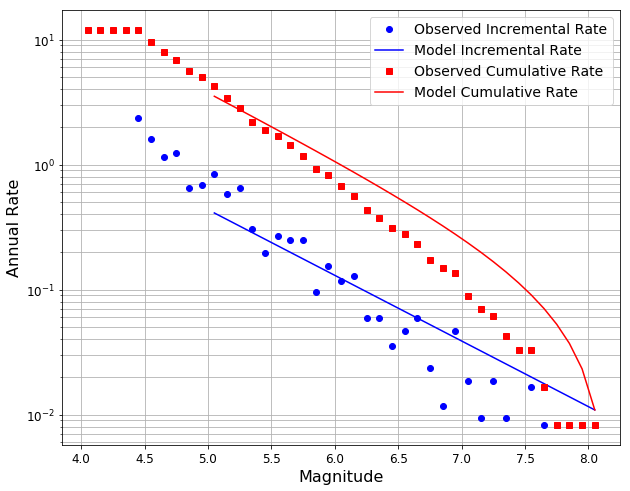

In [16]:
plot_trunc_gr_model(aval_wei, bval_wei, mmin_model, mmax_obs, binwidth, catalogue=fcatal,
        completeness=compl_table)

In [17]:
#
# Update the project info
c = Counter(fcatal.data['comment'])
weights = {}
annual_rate_source = []
#
# 
for srcid in area_source_ids_list:
    #
    # Computing weight
    num_eqs_source = float(c['%s' % srcid])
    weights[srcid] = num_eqs_source / fcatal.get_number_events()
    print ('source', srcid, \
           ' | num. of eqks [eqks] %6.2f' % (c['%s' % srcid]), \
           ' | weight %s' % (weights[srcid]))
    #
    # attaching source to model 
    src = model.get_source(srcid) 
    src.a_gr=numpy.log10(10**aval_wei * weights[srcid])
    src.b_gr=bval_wei
#
# saving the project
oqtkp.save(log=True)
#
# check of the weight
checkw = 0.0
for key in weights:
    checkw += weights[key]
print ('check:', checkw)

source 1  | num. of eqks [eqks] 513.00  | weight 1.0
Project saved into file /Users/kjohnson/GEM/Regions/paisl18/project_6/paisl.oqmbtp
check: 1.0


In [18]:
# Set table
p = PrettyTable(["ID","a_gr", "b_gr"])
p.align["Source ID"] = 'l'
p.align["a_gr"] = 'r'
p.align["b_gr"] = 'r'
#
for key in sorted(model.sources):
    src = model.sources[key]
    if src.source_type == 'AreaSource':
        alab = ''
        blab = ''
        if 'a_gr' in src.__dict__:
            alab = '%8.5f' % (src.a_gr)
        if 'b_gr' in src.__dict__:
            blab = '%6.3f' % (src.b_gr)    
        p.add_row([key, alab, blab])
print (p)

+----+----------+--------+
| ID |     a_gr |   b_gr |
+----+----------+--------+
| 1  |  3.18194 |  0.525 |
| 10 |          |        |
| 11 |          |        |
| 12 |          |        |
| 13 |          |        |
| 14 |          |        |
| 15 |          |        |
| 2  |          |        |
| 3  |          |        |
| 4  |          |        |
| 5  |          |        |
| 6  |          |        |
| 7  |          |        |
| 8  |          |        |
| 9  |          |        |
+----+----------+--------+
